In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mpath
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator
from scipy.spatial import Delaunay
import sys
import os
import json
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import Model
from tqdm import tqdm
from codebase.sinn_functions_2 import *

In [ ]:
filePath = 'datasets/dataLowReFLow4.json'
derL = 0.1
pressubeBC = True
data = loadData(filePath,derL,pressubeBC)

data_train = data[:-10]
data_test = data[-10:]
data_test_remesh = [RemeshData(data_i,0.2) for data_i in data_test[:10]]
data_train_remesh = [RemeshData(data_i,0.2) for data_i in data_train[:10]]


batch_size = [128,64,16]
n_batches = 1_000
n_epochs = 5
layers = [256,256,256,256]
elSize = 0.23
hyperParams = {'N_interiorEncoder': None, 'd_interiorEncoder': 3, 'layers_interiorEncoder': layers,
               'N_boundarEncoder': None, 'd_boundarEncoder': data[0]['interpBS'][0].spline.c.shape[-1], 'layers_boundarEncoder': layers,
               'N_decoderOut': None, 'd_decoderOut': 2, 'layers_decoder': layers[:2],
               'n_latent': 9, 'activation': 'relu', 'elSizeMax': [elSize,elSize,0.25], 'elSizeMin': [elSize-0.001,elSize-0.001,0.25-0.001], 'variableElSize': None,
               'nIE1': 6, 'nIE2': 8, 'kIE': 1, 'sizeIE': 0.2, 'typeIE': 'radial',
               'nBE': 20, 'kBE': 0.7, 'sizeBE': 1,
               'nD1': 0, 'nD2': 0, 'kD': 0.5, 'sizeD': 0.1,
               'fd_l_weight': 0.06, 'elliptc_weight': 0}

if hyperParams['typeIE'] == 'radial':
    nodesIE = GetRadialEncoderInputMask(hyperParams['nIE1'],hyperParams['nIE2'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
elif hyperParams['typeIE'] == 'squeare':
    nodesIE = GetSquareEncoderInputMask(hyperParams['nIE1'],hyperParams['nIE2'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
else:
    raise ValueError('typeIE must be either "radial" or "squeare"')

distanceBE = GetBoundaryEncoderInputMask(hyperParams['nBE'],k=hyperParams['kBE'],Esize=hyperParams['sizeBE'])
nodesD = GetRadialEncoderInputMask(hyperParams['nD1'],hyperParams['nD2'],k=hyperParams['kD'],Esize=hyperParams['sizeD'])
hyperParams['N_interiorEncoder'] = nodesIE.shape[0]
hyperParams['N_boundarEncoder'] = distanceBE.shape[0]
hyperParams['N_decoderOut'] = nodesD.shape[0]
hyperParams['nodesIE'] = nodesIE.tolist()
hyperParams['distanceBE'] = distanceBE.tolist()
hyperParams['nodesD'] = nodesD.tolist()

dataset = GetInteriorDatasetFixed(data_train[:1], nodesIE, nodesD, batch_size=batch_size[0], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'][0], elSizeMax=hyperParams['elSizeMax'][0], variableElSize=hyperParams['variableElSize'])
dataset_b = GetBoundaryDatasetFixed(data_train[:1], nodesIE, distanceBE, nodesD, batch_size=batch_size[1], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'][1], elSizeMax=hyperParams['elSizeMax'][1], elSizeBF=hyperParams['variableElSize'])
dataset_c = GetCornerDatasetFixed(data_train[:1], nodesIE, distanceBE, nodesD, batch_size=batch_size[2], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'][2], elSizeMax=hyperParams['elSizeMax'][2])

encoder,encoderB,decoder = GetModels(hyperParams)
P = tf.Variable(tf.constant(tf.eye(hyperParams['n_latent']*2),dtype=tf.float32))
r = hyperParams['n_latent']
history = GetEmptyHistory()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

history = TrainModel(encoder, encoderB, decoder, P, optimizer, dataset, dataset_b, dataset_c, r, n_epochs, n_batches, hyperParams,history=history,data_test=data_test_remesh[:10],data_train=data_train_remesh[:1])

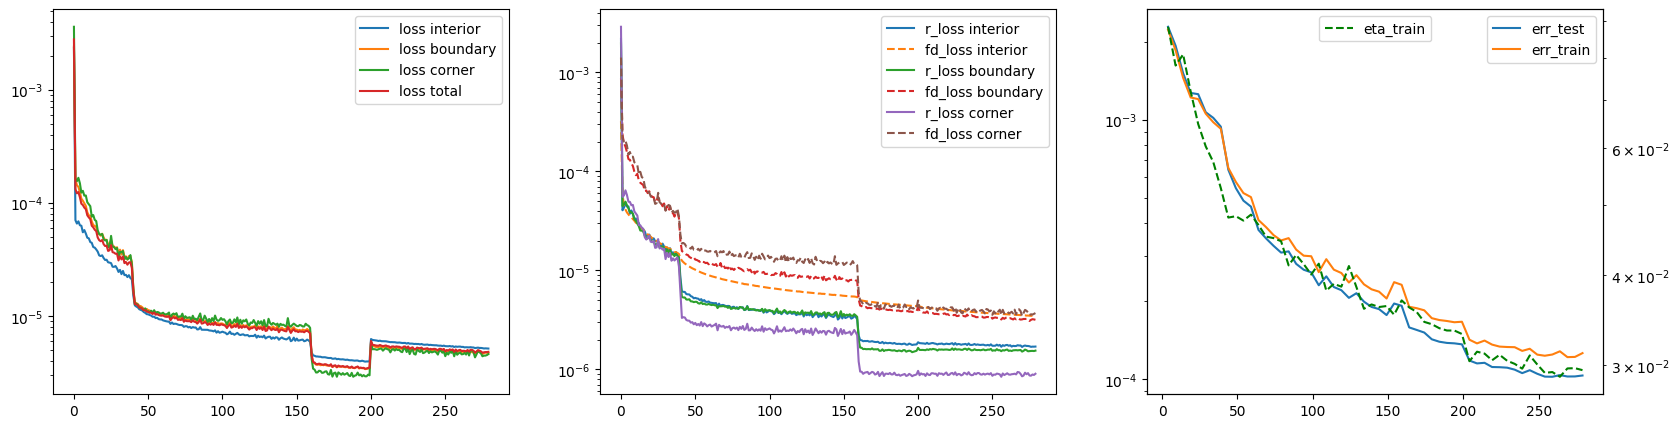

In [12]:
%matplotlib inline
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(history['loss_i'],label='loss interior')
plt.plot(history['loss_b'],label='loss boundary')
plt.plot(history['loss_c'],label='loss corner')
plt.plot(history['loss'],label='loss total')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,2)
plt.plot(history['r_loss_i'],label='r_loss interior')
plt.plot(np.array(history['fd_l_loss_i'])*hyperParams['fd_l_weight'],label='fd_loss interior', linestyle='--')
plt.plot(history['r_loss_b'],label='r_loss boundary')
plt.plot(np.array(history['fd_l_loss_b'])*hyperParams['fd_l_weight'],label='fd_loss boundary', linestyle='--')
plt.plot(history['r_loss_c'],label='r_loss corner')
plt.plot(np.array(history['fd_l_loss_c'])*hyperParams['fd_l_weight'],label='fd_loss corner', linestyle='--')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,3)
plt.plot(history['err_epoch'],history['err_test'],label='err_test')
plt.plot(history['err_epoch'],history['err_train'],label='err_train')
plt.legend()
plt.gca().set_yscale('log')
plt.gca().twinx()
# plt.plot(history['err_epoch'],history['eta_test'],'--',label='eta_test',color='r')
plt.plot(history['err_epoch'],history['eta_train'],'--',label='eta_train',color='g')
plt.legend(loc = 'upper center')
plt.gca().set_yscale('log')

In [11]:
modelFolder = r'models/sinn_test_case_2'
encoder,encoderB,decoder,P,history,hyperParams = LoadModels(modelFolder)
r = hyperParams['n_latent']
nodesIE = np.array(hyperParams['nodesIE'])
distanceBE = np.array(hyperParams['distanceBE'])
nodesD = np.array(hyperParams['nodesD'])

Encoded latent fields


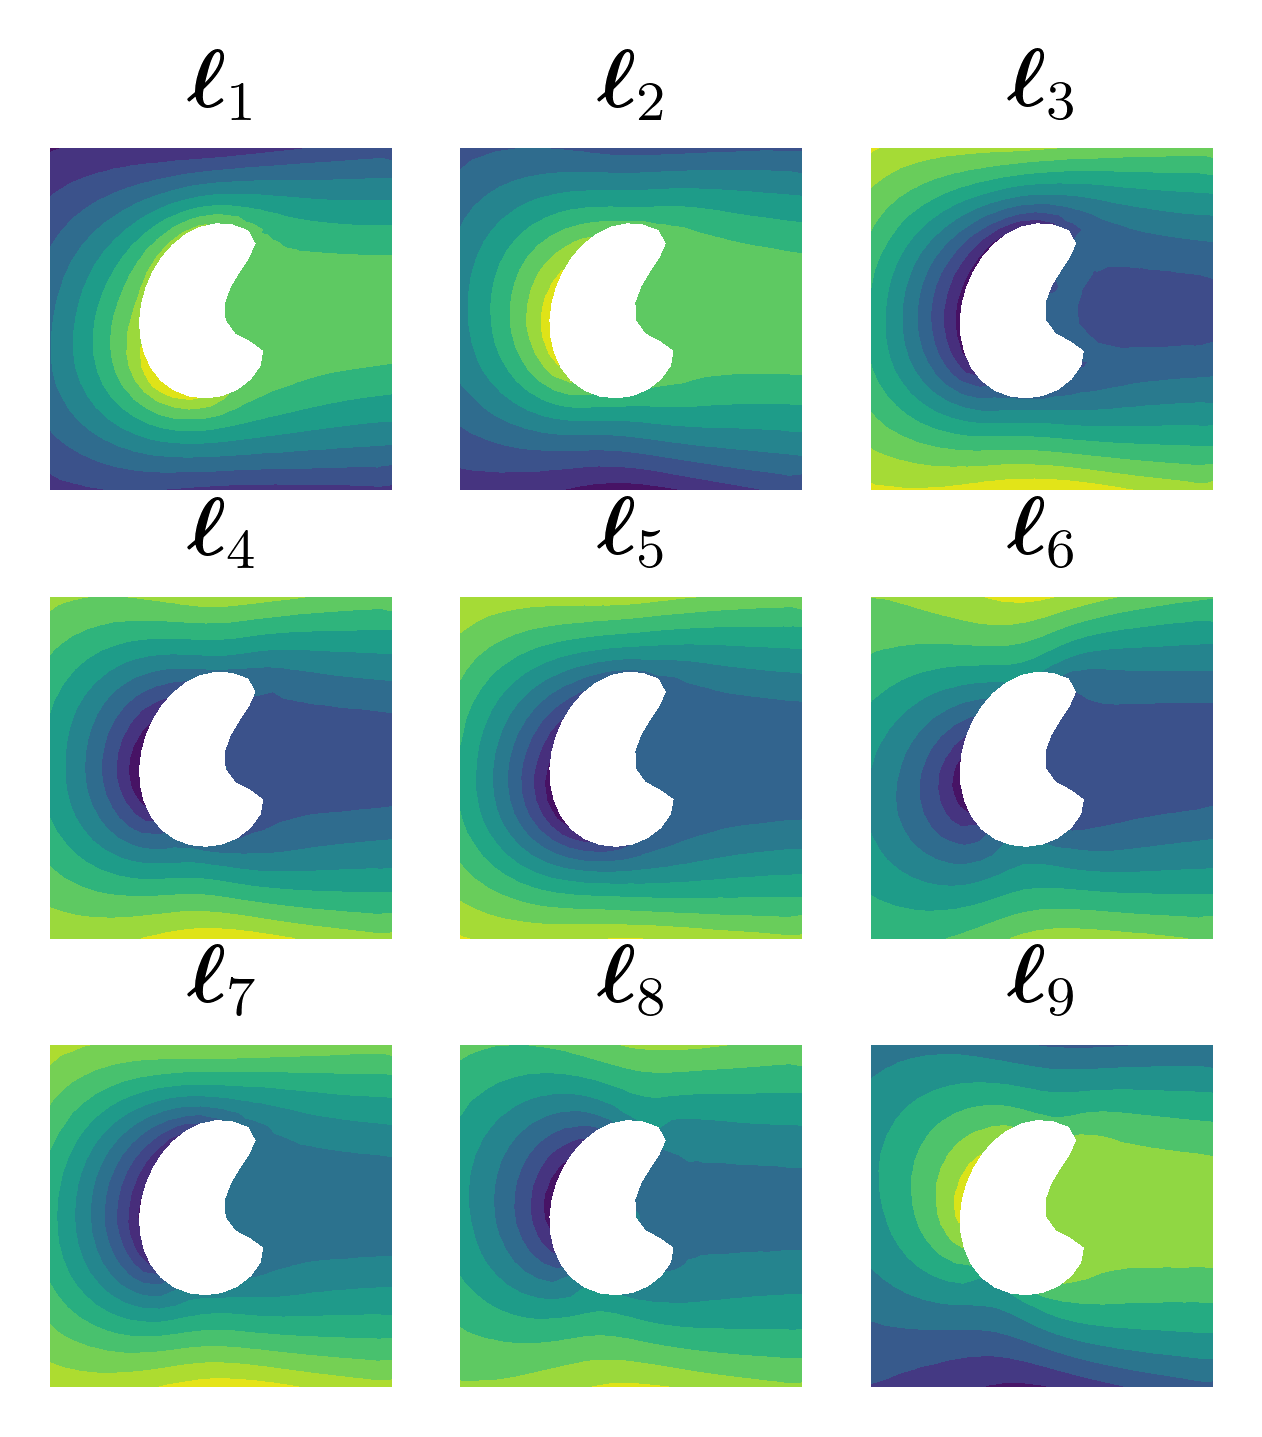

Solved latent fields


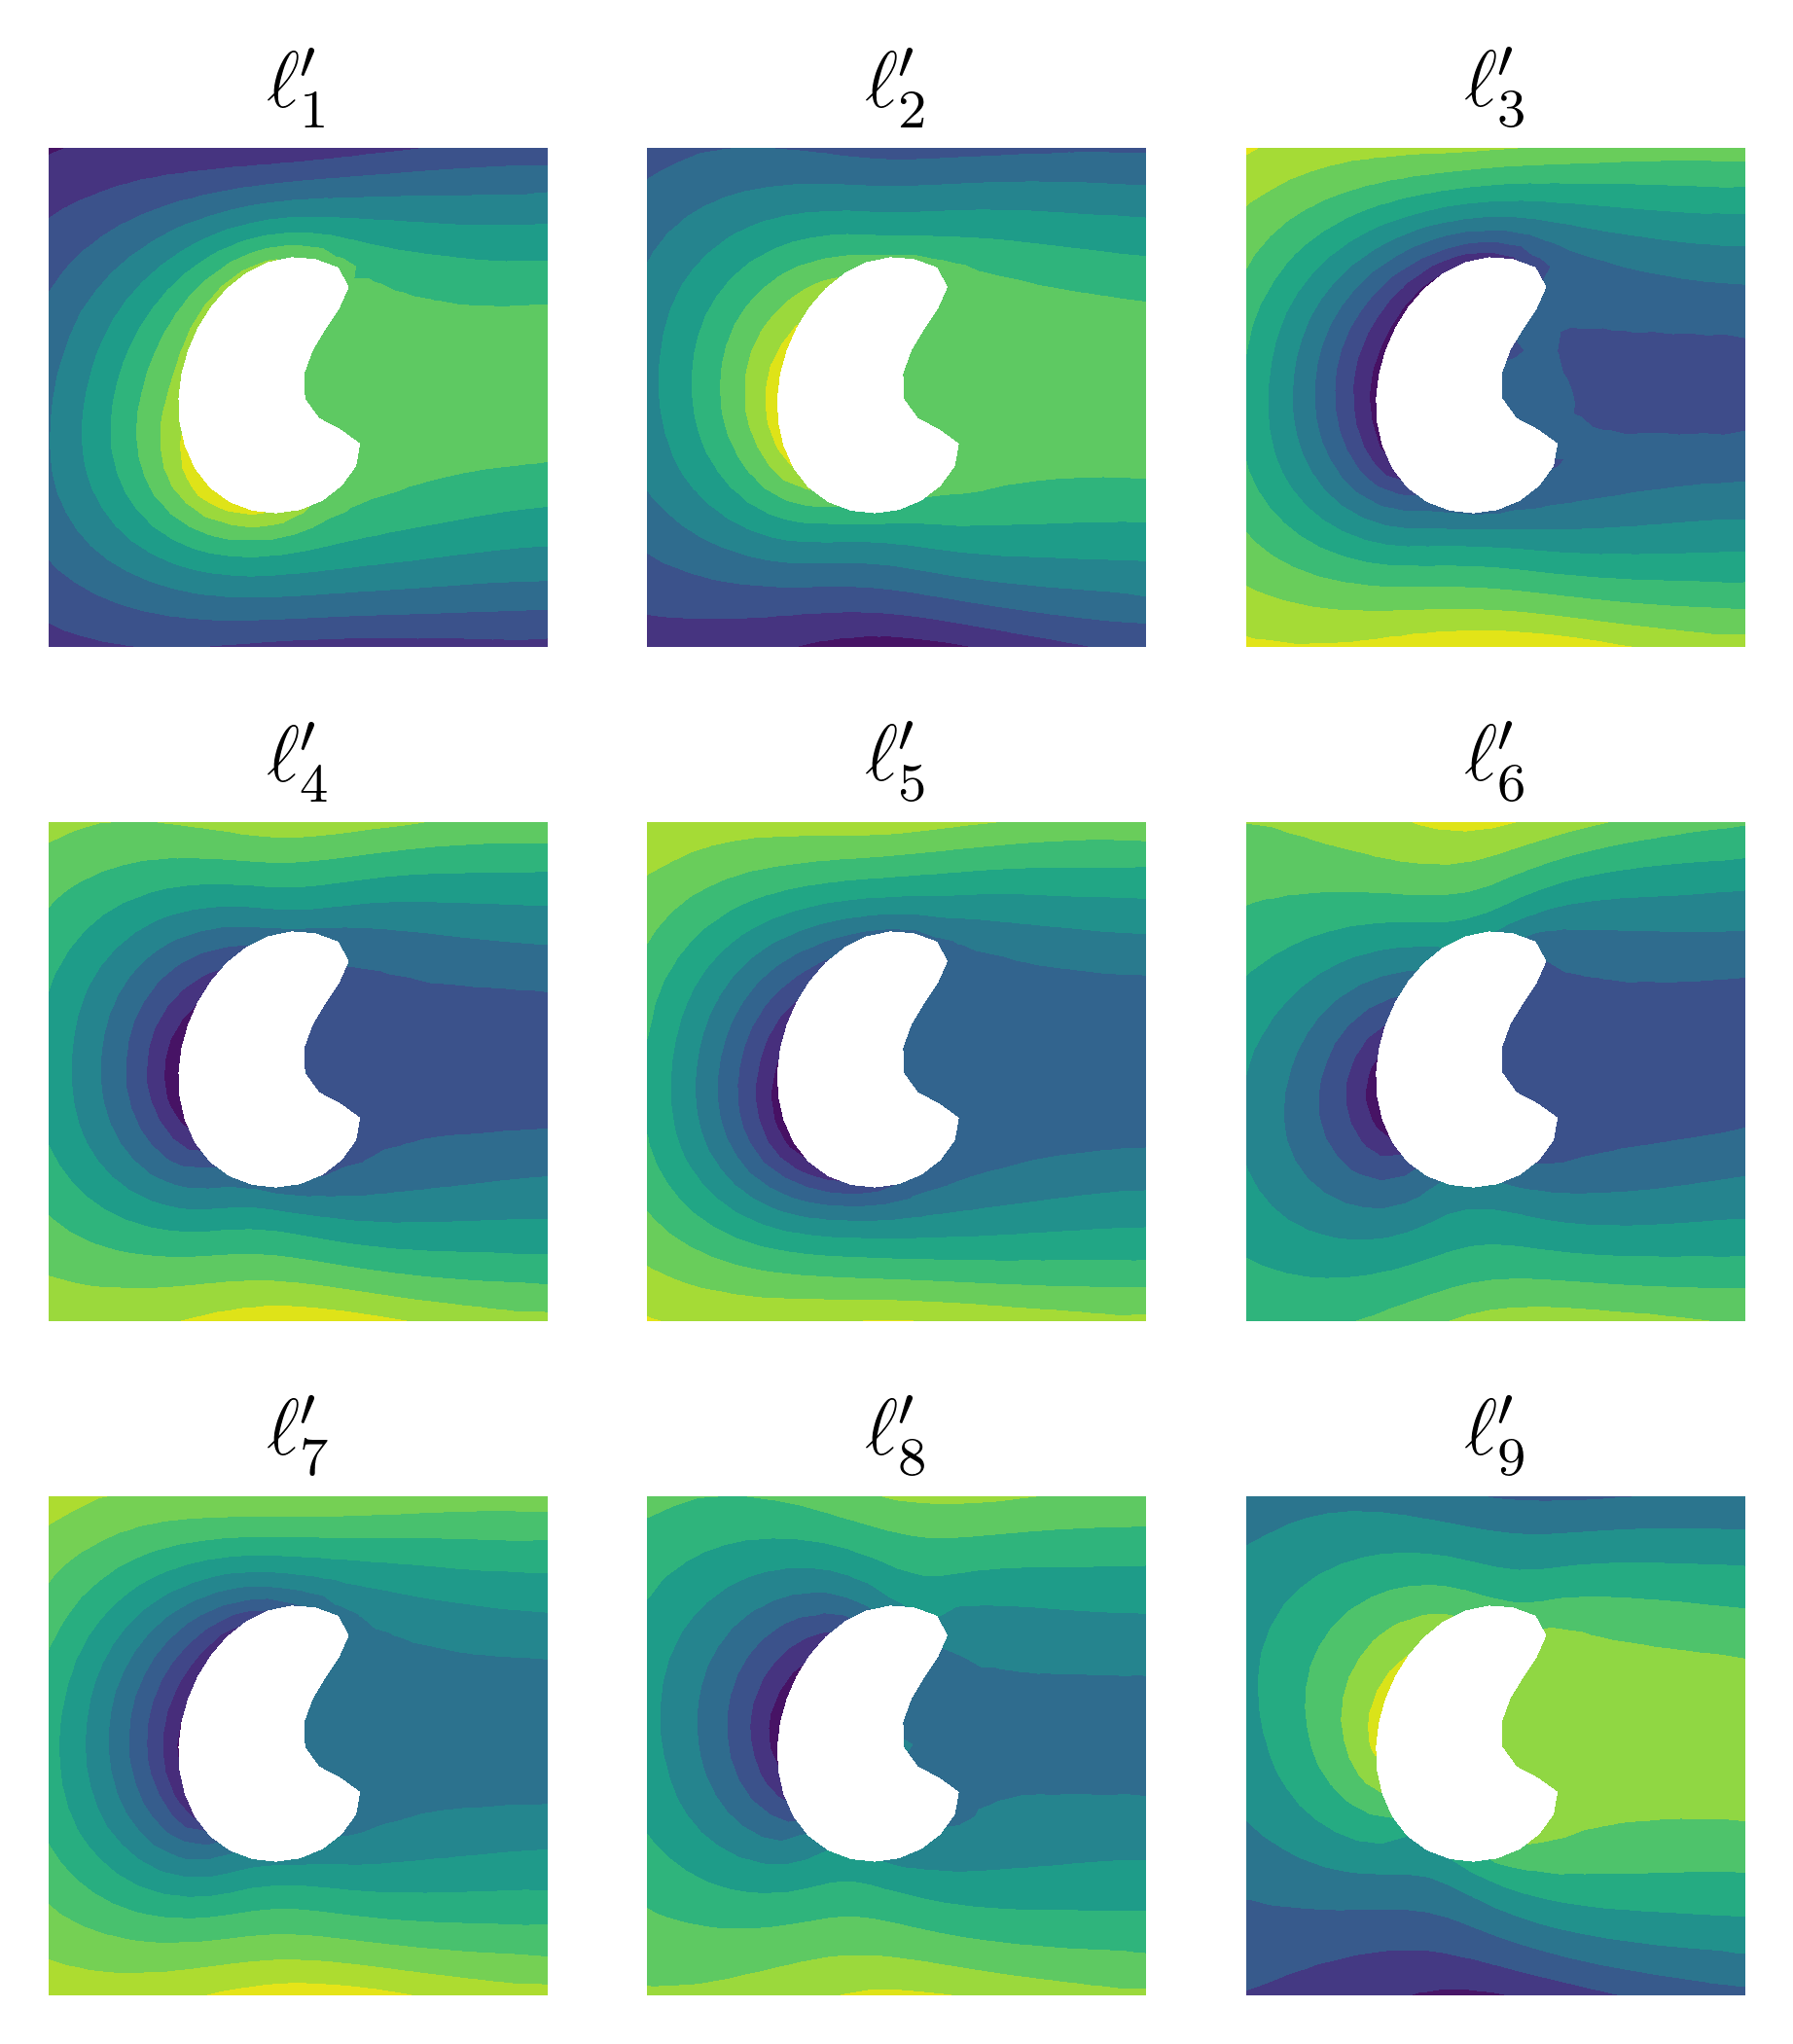

SINN predicted velocity fields


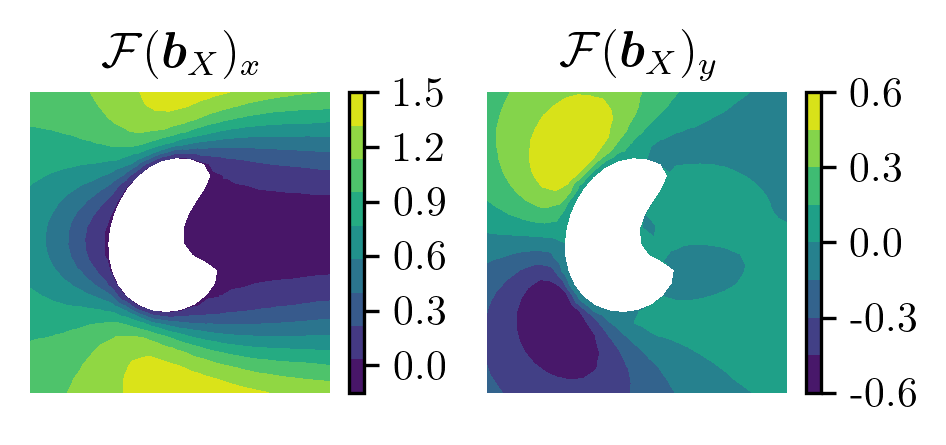

True velocity fields


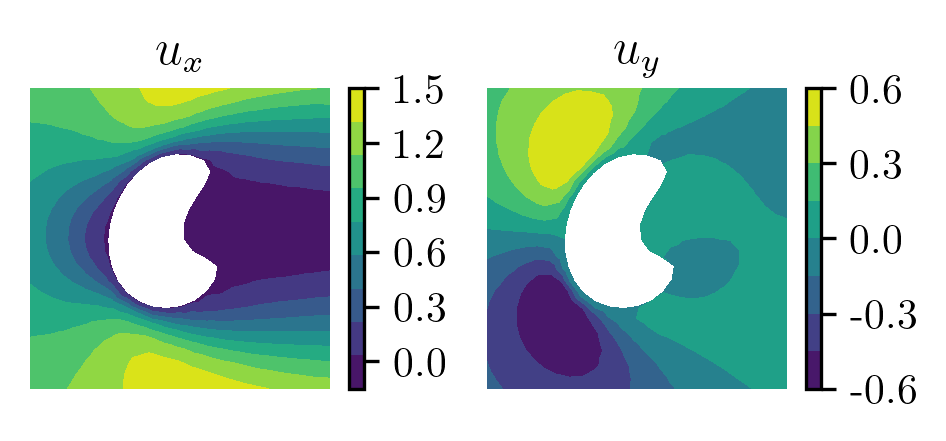

Error velocity fields


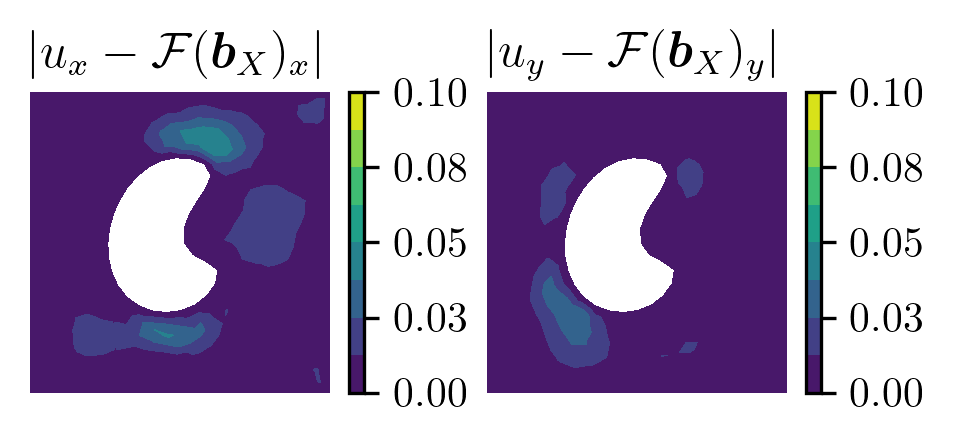

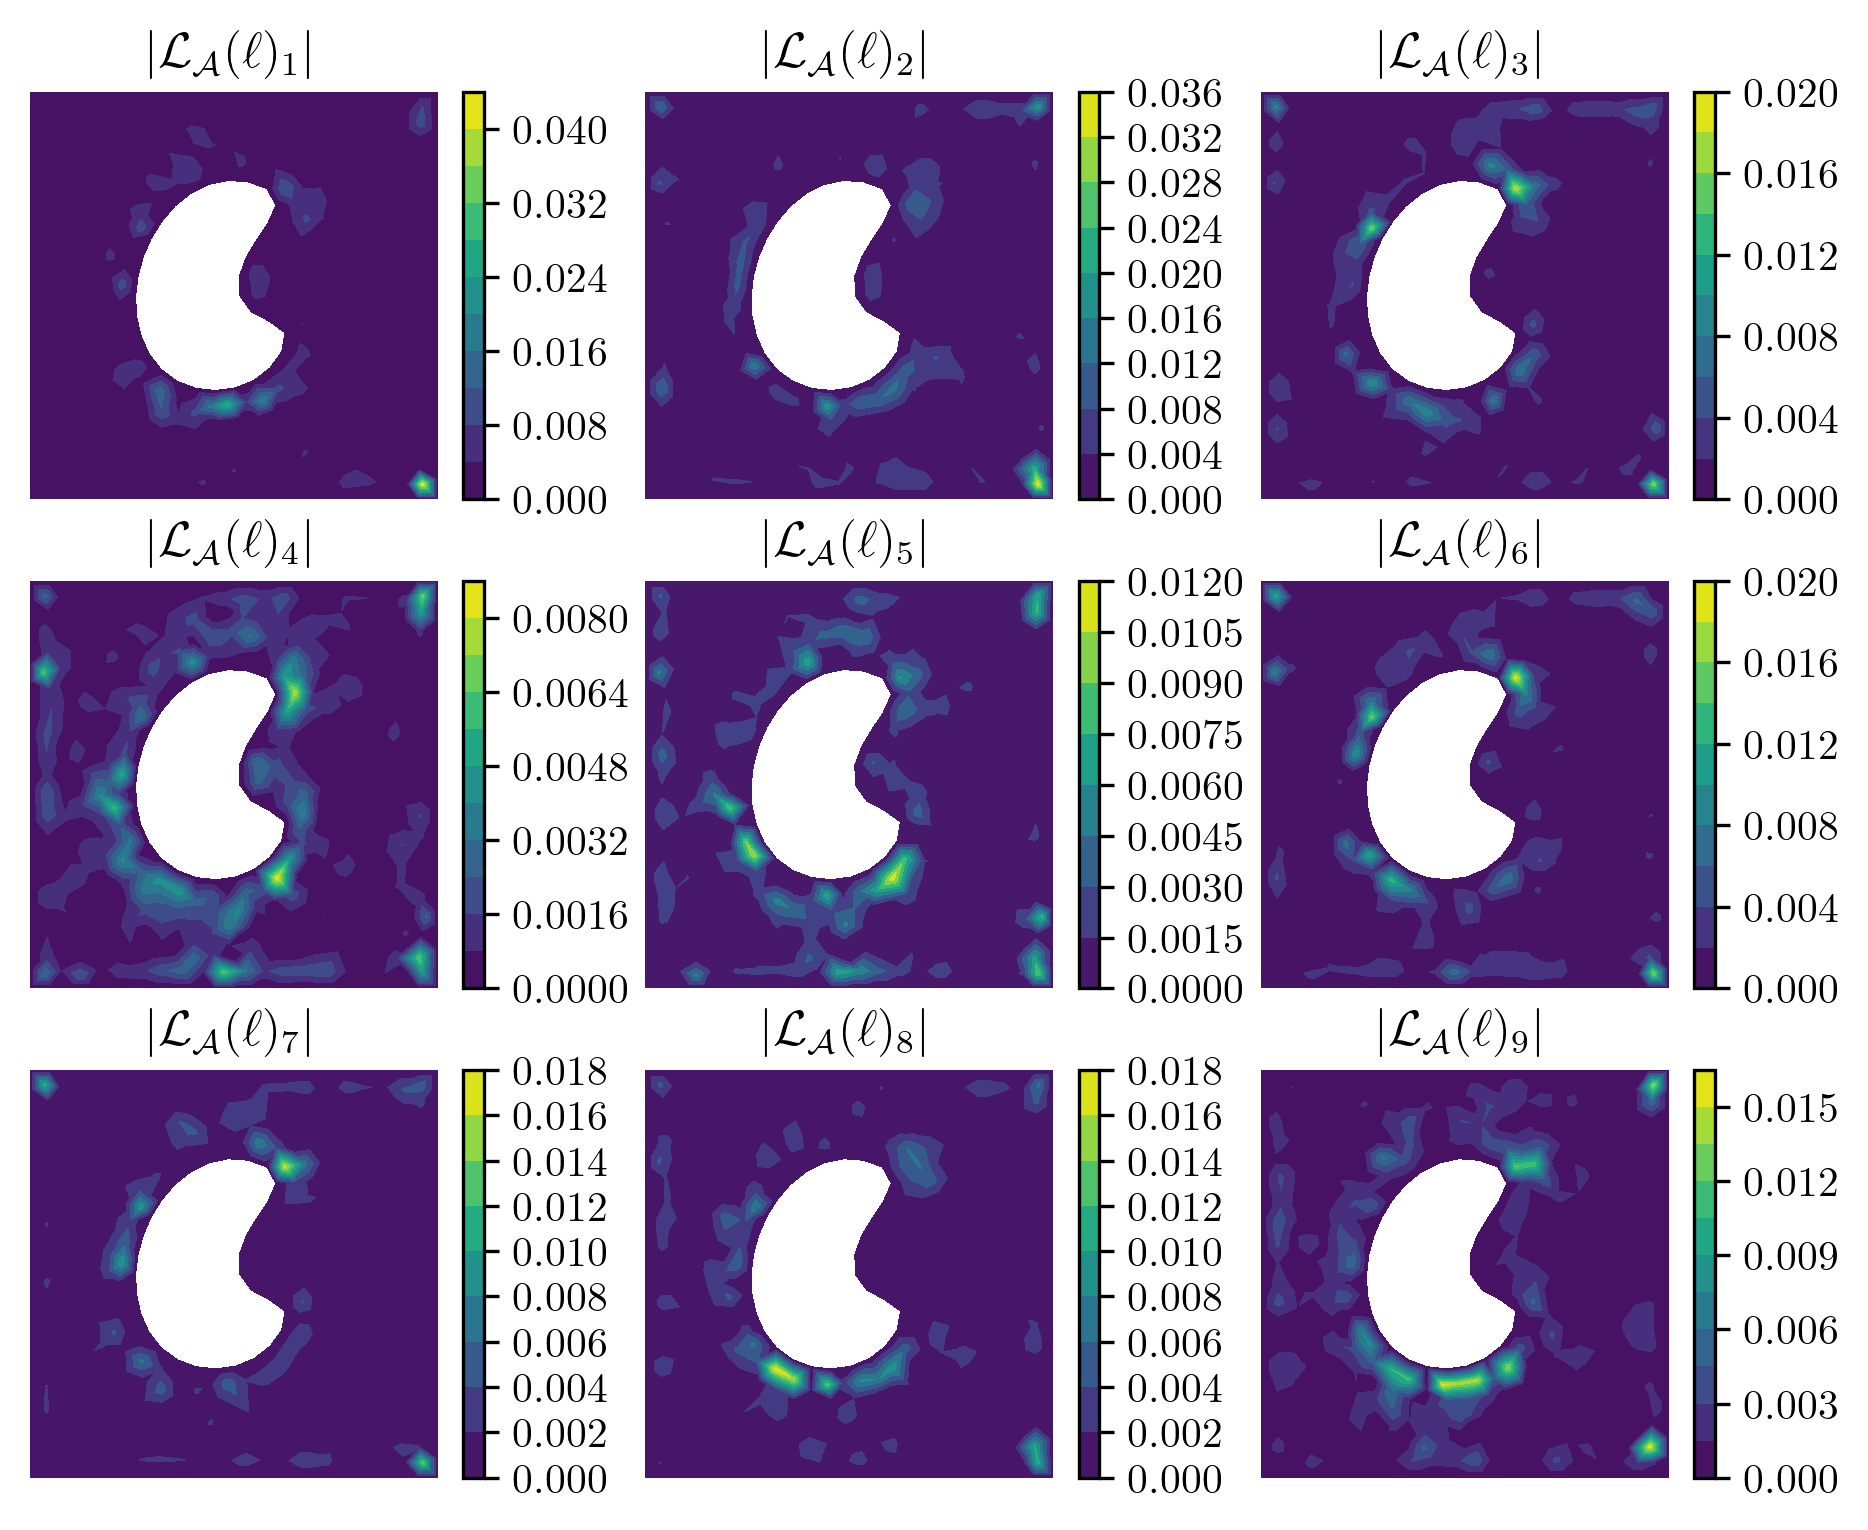

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update({
    "text.usetex": True,                 # use LaTeX for all text
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],  # default LaTeX font
    "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{amsmath}",
    "axes.unicode_minus": False,
})

def GenerateGeometry2(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    
    for i in range(4):
        g.line([i,(i+1)%4],marker=1)
    g.spline(list(range(4,p.shape[0]))+[4],marker=2)
    g.surface([0,1,2,3],[[4]])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = [np.array(bdofs[1])-1,np.array(bdofs[2])-1]
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), np.concatenate(boundaryNodes))
    return nodes, elements, boundaryNodes, internalNodes

def computeLengthAlongCurve(nodesB):
    dl = np.sqrt(((nodesB[1:]-nodesB[:-1])**2).sum(1))
    l = np.cumsum(dl)
    l = np.concatenate([[0],l],0)
    return l

def PlotMesh(nodes, boundaryNodes, elements):
    plt.figure(figsize=(10,10))
    plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    elif elements.shape[1] == 3:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k')
    for i in range(len(boundaryNodes)):
        plt.plot(nodes[boundaryNodes[i],0],nodes[boundaryNodes[i],1],'r')
    plt.gca().set_aspect('equal', adjustable='box')

def PlotFEMsolution(nodes, elements,l, axisLabels = True, useColorBar = True, labels = False, subplotsize=(6,5),dpi = 100, levels=10, levels_colorbar=None, n_floats=1):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    r = l.shape[1]
    if isinstance(levels,int):
        levels = [levels]*r
    else:
        l = l.copy()
        for i in range(r):
            l[l[:,i]>levels[i][-1],i] = levels[i][-1]-0.001
            l[l[:,i]<levels[i][0],i] = levels[i][0]+0.001


    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    n_rows = np.ceil(r/3).astype(int)
    n_cols = min(r,3)
    fig = plt.figure(figsize=(subplotsize[0]*n_cols,subplotsize[1]*n_rows),dpi=dpi)
    for i in range(r):
        ax = plt.subplot(n_rows,n_cols,i+1)
        contour = ax.tricontourf(triangulation, l[:,i],levels[i])
        # plt.scatter(nodes[:,0],nodes[:,1],s=100,c=l[:,i])
        # if useColorBar:
        #     plt.colorbar()
        if useColorBar:
            cbar = plt.colorbar(contour, ax=ax, location="right", shrink=1)
            if levels_colorbar is not None:
                y_ticks = np.array(levels_colorbar[i])
                cbar.set_ticks(y_ticks)
                cbar.set_ticklabels([f"{num:.{n_floats}f}" for num in y_ticks])
                # cbar.ax.tick_params(labelsize=font_size)
        if axisLabels:
            plt.xlabel('$x$')
            plt.ylabel('$y$')
        else:
            plt.axis('off')
        if labels:
            plt.title(labels[i])
        plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return

def residualFEM(nodes, elements, boundaryNodes, l, internalNodes, r, A_l):

    # Assemble the global stiffness matrix
    res = np.zeros((nodes.shape[0], r))
    res_flat = res.flatten()
    l_flat = l.flatten()
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        K_el = GetK_el_triang(A_l,nodes_el)
        res_flat[el_idx] += K_el @ l_flat[el_idx]


    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    res_flat[bc_idx] = 0
    res = res_flat.reshape(-1,r)
    return res

idx = 1
data_idx_remeshed = data_test_remesh[idx]

l = EncodeData(data_idx_remeshed,encoder,encoderB, nodesIE, distanceBE)
nodes = data_idx_remeshed['nodes']
elements = data_idx_remeshed['elements']

print("Encoded latent fields")
PlotFEMsolution(nodes, elements,l,useColorBar=False, axisLabels=False, labels=[r'$\boldsymbol{\ell}_{'+str(i+1)+r'}$' for i in range(r)],subplotsize=(1.0,1.1),dpi=500)

u_model, l_model = SINNsPredict(data_idx_remeshed,encoderB,decoder,P,r,distanceBE)

u_data = data_idx_remeshed['solution'][...,:2]
levels = [np.linspace(-0.15,1.5,10), np.linspace(-0.6,0.6,9)]
levels_colorbar = [[0,0.3,0.6,0.9,1.2,1.5],[-0.6,-0.3,0.0,0.3,0.6]]

levels_err = [np.linspace(0,0.1,9), np.linspace(0,0.1,9)]
levels_err_colorbar = [np.linspace(0,0.1,5),np.linspace(0,0.1,5)]

print("Solved latent fields")
PlotFEMsolution(nodes, elements,l_model,useColorBar=False, axisLabels=False, labels=[f'$\ell_{i+1}\'$' for i in range(r)],subplotsize=(1.5,1.7),dpi=500)
print("SINN predicted velocity fields")
PlotFEMsolution(nodes, elements,u_model,axisLabels=False,labels=[r'$\mathcal{F}(\boldsymbol{b}_X)_x$',r'$\mathcal{F}(\boldsymbol{b}_X)_y$'],subplotsize=(1.8,1.3),dpi=300, levels=levels, levels_colorbar=levels_colorbar)
print("True velocity fields")
PlotFEMsolution(nodes, elements,data_idx_remeshed['solution'][...,:2],axisLabels=False,labels=['$u_x$','$u_y$'],subplotsize=(1.8,1.3),dpi=300, levels=levels, levels_colorbar=levels_colorbar)
print("Error velocity fields")
PlotFEMsolution(nodes, elements,np.abs(data_idx_remeshed['solution'][...,:2]-u_model),axisLabels=False,labels=[r'$|u_x-\mathcal{F}(\boldsymbol{b}_X)_x|$',r'$|u_y-\mathcal{F}(\boldsymbol{b}_X)_y|$'],subplotsize=(1.8,1.3),dpi=300, levels=levels_err, levels_colorbar=levels_err_colorbar,n_floats=2)

r = hyperParams['n_latent']
boundaryNodes = np.concatenate([idxCurve[:-1] for idxCurve in data_idx_remeshed['idxCurves']])
internalNodes = data_idx_remeshed['internalNodes']
res = residualFEM(nodes, elements, boundaryNodes, l, internalNodes, r, GetA(P).numpy())
PlotFEMsolution(nodes, elements,np.abs(res),axisLabels=False,labels=[' $ |\mathcal{L}_\mathcal{A}(\ell)_{'+str(i+1)+'}|$ ' for i in range(r)],subplotsize=(2.5,2),dpi=300)
